### Imports

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef

import importlib.util
import sys

import ROOT
ROOT.gSystem.Load('../RooUnfold/build/libRooUnfold.so')


def import_module_from_path(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

omnifold_bdt = import_module_from_path("omnifold", "../unfolding/omnifold.py")
data_handler = import_module_from_path("data_handler", "../unfolding/data_handler.py")

omnifold_dnn = import_module_from_path("omnifold", "../OmniFold/omnifold.py")
modplot = import_module_from_path("modplot", "../OmniFold/modplot.py")
ibu = import_module_from_path("ibu", "../OmniFold/ibu.py")



### Plot Style

In [61]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'


In [62]:
num_data = 100000

datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=num_data, exclude_keys=['particles']),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=num_data, exclude_keys=['particles'])}

In [63]:
# choose what is MC and Data in this context
synthetic, nature = datasets['Pythia26'], datasets['Herwig']

In [64]:
# how many iterations of the unfolding process
itnum = 3

In [65]:
obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']

In [66]:
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,3],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mults'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_widths'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau2s']/(dset[ptype + '_widths'] + 10**-50),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zgs'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, 
    ptype: np.log(dset[ptype + '_sdms']**2/
                                       dset[ptype + '_jets'][:,0]**2 + 10**-100),
    'nbins_det': 50, 
    'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '"Truth"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
binned_omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}
unbinned_omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:blue', 'zorder': 3}

Now all that remains is to get the values of the specified observables and compute the histograms with the specified binnings. As an unfolding benchmark, we also obtain the unfolding results of Iterative Bayesian Unfolding (IBU) as implemented in `ibu.py`. The following cell takes care of all of these aspects.

In [67]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():

    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'sim')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                         ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


# Unbinned BDT Omnifold

In [68]:
mc_data = np.asarray([(obs[obkey]['genobs']) for obkey in obs_multifold]).T
sim_data = np.asarray([(obs[obkey]['simobs']) for obkey in obs_multifold]).T
meas_data = np.asarray([(obs[obkey]['dataobs']) for obkey in obs_multifold]).T
true_data = np.asarray([(obs[obkey]['truthobs']) for obkey in obs_multifold]).T

pass_reco_mask = np.full(num_data, True)
pass_truth_mask = np.full(num_data, True)

unbinned_results = []
for i in range(len(obs_multifold)):
    omnifold_weights, MC_test, _, _  = omnifold_bdt.unbinned_omnifold(mc_data[:,i], sim_data[:,i], meas_data[:,i], pass_reco_mask, pass_truth_mask, itnum)
    unbinned_results.append((omnifold_weights, MC_test))

Starting iteration 0


Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2


# Binned BDT Omnifold

In [69]:
sim_data_mass, sim_data_width, sim_data_mult, sim_data_lnrho, sim_data_zgs, sim_data_tau21 = [], [], [], [], [], []
mc_data_mass, mc_data_width, mc_data_mult, mc_data_lnrho, mc_data_zgs, mc_data_tau21 = [], [], [], [], [], []
meas_data_mass, meas_data_width, meas_data_mult, meas_data_lnrho, meas_data_zgs, meas_data_tau21 = [], [], [], [], [], []

for i in range(len(meas_data)):
    meas_data_mass.append(meas_data[i][0])
    meas_data_mult.append(meas_data[i][1])
    meas_data_width.append(meas_data[i][2])
    meas_data_tau21.append(meas_data[i][3])
    meas_data_zgs.append(meas_data[i][4])
    meas_data_lnrho.append(meas_data[i][5])

    mc_data_mass.append(mc_data[i][0])
    mc_data_mult.append(mc_data[i][1])
    mc_data_width.append(mc_data[i][2])
    mc_data_tau21.append(mc_data[i][3])
    mc_data_zgs.append(mc_data[i][4])
    mc_data_lnrho.append(mc_data[i][5])

    sim_data_mass.append(sim_data[i][0])
    sim_data_mult.append(sim_data[i][1])
    sim_data_width.append(sim_data[i][2])
    sim_data_tau21.append(sim_data[i][3])
    sim_data_zgs.append(sim_data[i][4])
    sim_data_lnrho.append(sim_data[i][5])


#Binned Data
bins_mass, bin_low_mass, bin_high_mass = obs['Mass']['nbins_det'], obs['Mass']['xlim'][0], obs['Mass']['xlim'][1]
bins_widths, bin_low_widths, bin_high_widths  = obs['Width']['nbins_det'], obs['Width']['xlim'][0], obs['Width']['xlim'][1]
bins_mult, bin_low_mult, bin_high_mult  = obs['Mult']['nbins_det'], obs['Mult']['xlim'][0], obs['Mult']['xlim'][1]
bins_lnrho, bin_low_lnrho, bin_high_lnrho  = obs['SDMass']['nbins_det'], obs['SDMass']['xlim'][0], obs['SDMass']['xlim'][1]
bins_zgs, bin_low_zgs, bin_high_zgs  = obs['zg']['nbins_det'], obs['zg']['xlim'][0], obs['zg']['xlim'][1]
bins_tau21, bin_low_tau21, bin_high_tau21  = obs['Tau21']['nbins_det'], obs['Tau21']['xlim'][0], obs['Tau21']['xlim'][1]

meas_data_mass_binned = ROOT.TH1D("meas_mass_hist", "meas_mass_hist", bins_mass, bin_low_mass, bin_high_mass)
meas_data_width_binned = ROOT.TH1D("meas_width_hist", "meas_width_hist", bins_widths, bin_low_widths, bin_high_widths)
meas_data_mult_binned = ROOT.TH1D("meas_mult_hist", "meas_mult_hist", bins_mult, bin_low_mult, bin_high_mult)
meas_data_lnrho_binned = ROOT.TH1D("meas_lnrho_hist", "meas_lnrho_hist", bins_lnrho, bin_low_lnrho, bin_high_lnrho)
meas_data_zgs_binned = ROOT.TH1D("meas_zgs_hist", "meas_zgs_hist", bins_zgs, bin_low_zgs, bin_high_zgs)
meas_data_tau21_binned = ROOT.TH1D("meas_tau21_hist", "meas_tau21_hist", bins_tau21, bin_low_tau21, bin_high_tau21)

response_mass = ROOT.RooUnfoldResponse(bins_mass, bin_low_mass, bin_high_mass, bins_mass, bin_low_mass, bin_high_mass)
response_width = ROOT.RooUnfoldResponse(bins_widths, bin_low_widths, bin_high_widths, bins_widths, bin_low_widths, bin_high_widths)
response_mult = ROOT.RooUnfoldResponse(bins_mult, bin_low_mult, bin_high_mult, bins_mult, bin_low_mult, bin_high_mult)
response_lnrho = ROOT.RooUnfoldResponse(bins_lnrho, bin_low_lnrho, bin_high_lnrho, bins_lnrho, bin_low_lnrho, bin_high_lnrho)
response_zgs = ROOT.RooUnfoldResponse(bins_zgs, bin_low_zgs, bin_high_zgs, bins_zgs, bin_low_zgs, bin_high_zgs)
response_tau21 = ROOT.RooUnfoldResponse(bins_tau21, bin_low_tau21, bin_high_tau21, bins_tau21, bin_low_tau21, bin_high_tau21)

Warning in <TROOT::Append>: Replacing existing TH1: meas_mass_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: meas_width_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: meas_mult_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: meas_lnrho_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: meas_zgs_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: meas_tau21_hist (Potential memory leak).


In [70]:

#Unbinned data and fill response matrices
def build_data(
        response, 
        initial_mc_list, 
        initial_sim_list, 
        initial_measured_list, 
        measured_hist, 
    ):

    for MC, sim, measured in zip(initial_mc_list, initial_sim_list, initial_measured_list):
        response.Fill(sim, MC)
        measured_hist.Fill(measured)
        
    return response, measured_hist

response_mass, meas_data_mass_binned = build_data(
    response_mass,
    mc_data_mass,
    sim_data_mass,
    meas_data_mass,
    meas_data_mass_binned
)

response_mult, meas_data_mult_binned = build_data(
    response_mult,
    mc_data_mult,
    sim_data_mult,
    meas_data_mult,
    meas_data_mult_binned
)

response_width, meas_data_width_binned = build_data(
    response_width,
    mc_data_width,
    sim_data_width,
    meas_data_width,
    meas_data_width_binned
)

response_tau21, meas_data_tau21_binned = build_data(
    response_tau21,
    mc_data_tau21,
    sim_data_tau21,
    meas_data_tau21,
    meas_data_tau21_binned
)

response_zgs, meas_data_zgs_binned = build_data(
    response_zgs,
    mc_data_zgs,
    sim_data_zgs,
    meas_data_zgs,
    meas_data_zgs_binned
)

response_lnrho, meas_data_lnrho_binned = build_data(
    response_lnrho,
    mc_data_lnrho,
    sim_data_lnrho,
    meas_data_lnrho,
    meas_data_lnrho_binned
)

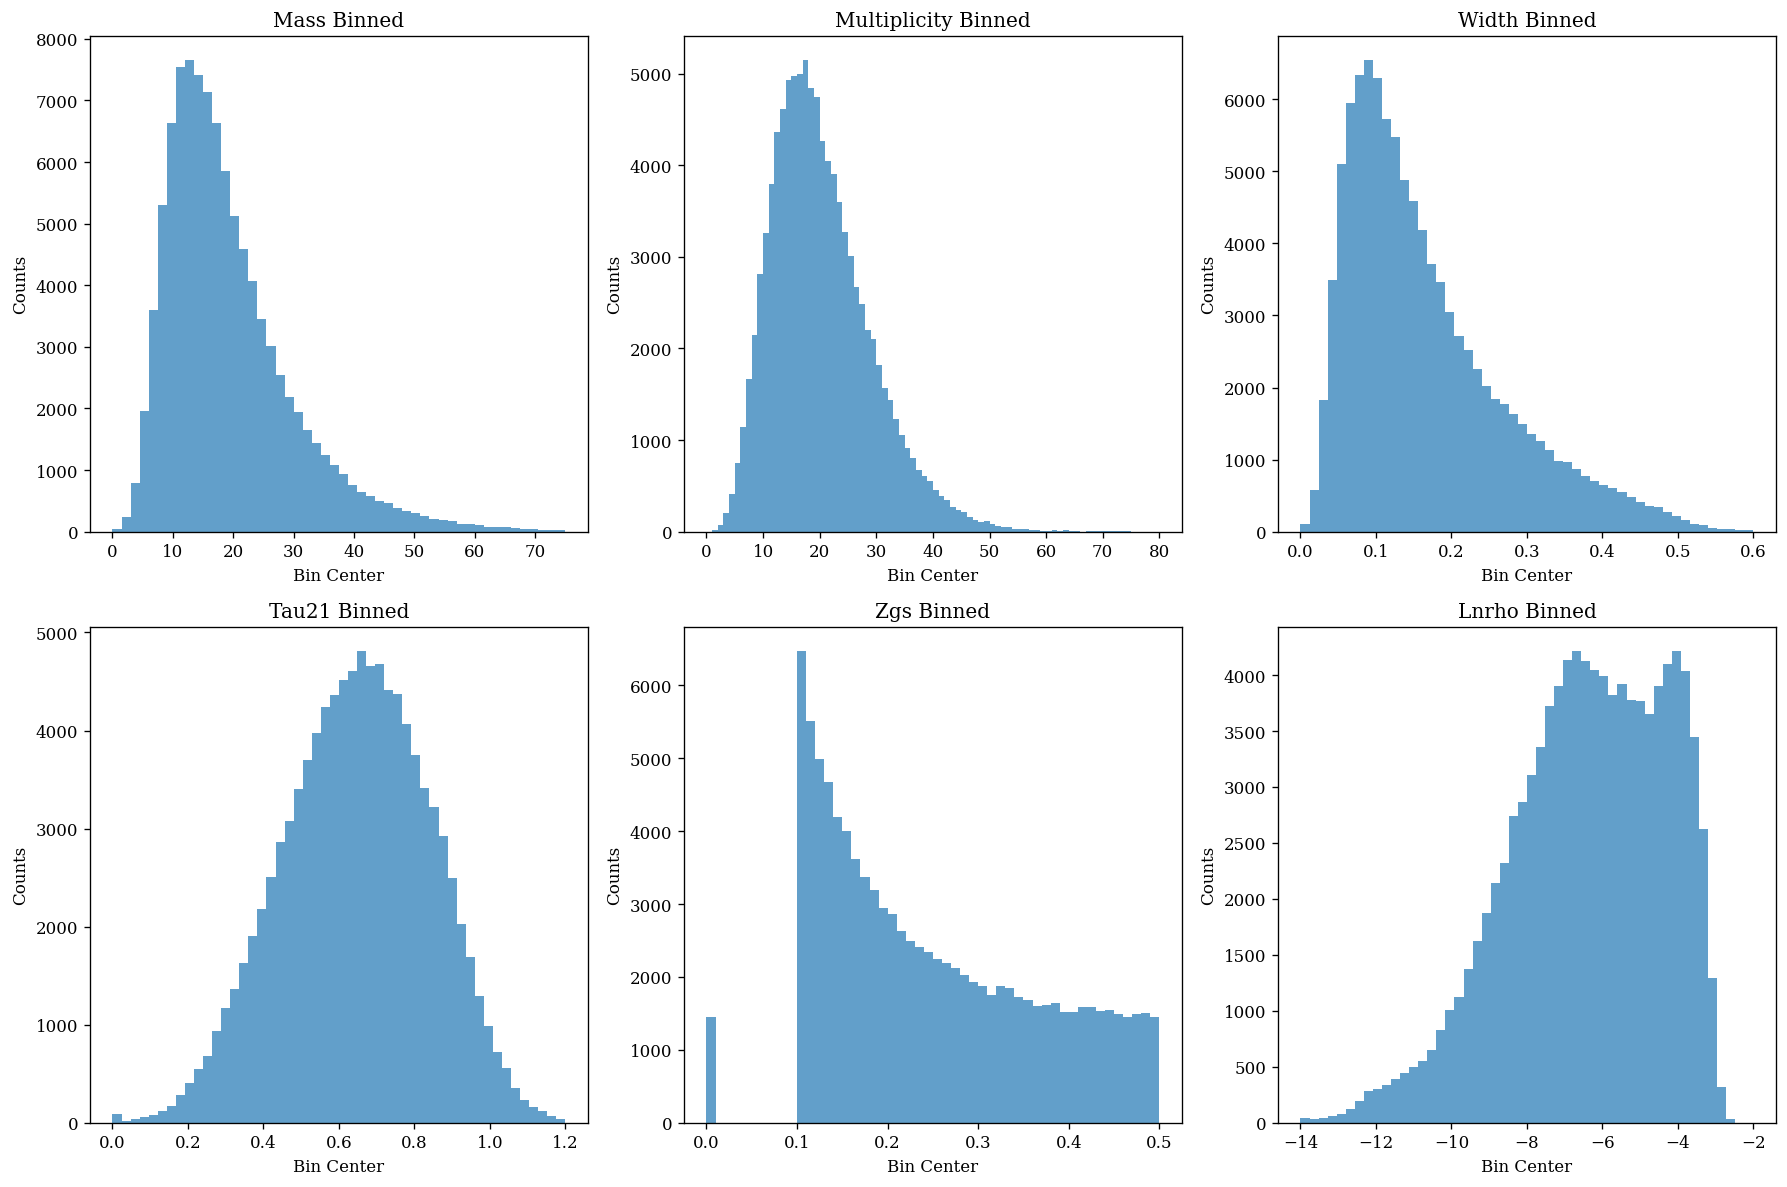

In [71]:
hists = [
    meas_data_mass_binned,
    meas_data_mult_binned,
    meas_data_width_binned,
    meas_data_tau21_binned,
    meas_data_zgs_binned,
    meas_data_lnrho_binned,
]


# Titles for each histogram
titles = [
    "Mass Binned",
    "Multiplicity Binned",
    "Width Binned",
    "Tau21 Binned",
    "Zgs Binned",
    "Lnrho Binned",
]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot each histogram
for i, histogram in enumerate(hists):
    bin_centers = [histogram.GetBinCenter(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    counts = [histogram.GetBinContent(bin) for bin in range(1, histogram.GetNbinsX() + 1)]
    
    axes[i].bar(bin_centers, counts, width=histogram.GetBinWidth(1), align='center', alpha=0.7)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Bin Center')
    axes[i].set_ylabel('Counts')

# Adjust layout
plt.tight_layout()
plt.show()

In [72]:
binned_datasets = [
    (response_mass, meas_data_mass_binned),
    (response_mult, meas_data_mult_binned),
    (response_width, meas_data_width_binned),
    (response_tau21, meas_data_tau21_binned),
    (response_zgs, meas_data_zgs_binned),
    (response_lnrho, meas_data_lnrho_binned),
]

binned_results = []
for response, measured_hist in binned_datasets:
    omnifold_weights, mc_test, _, _, = omnifold_bdt.binned_omnifold(response, measured_hist, itnum)
    binned_results.append((omnifold_weights, mc_test))

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 0
Starting iteration 1
Starting iteration 2


## Plot Unfolding Results

Now it's time to plot the unfolding results for all of the specified observables!

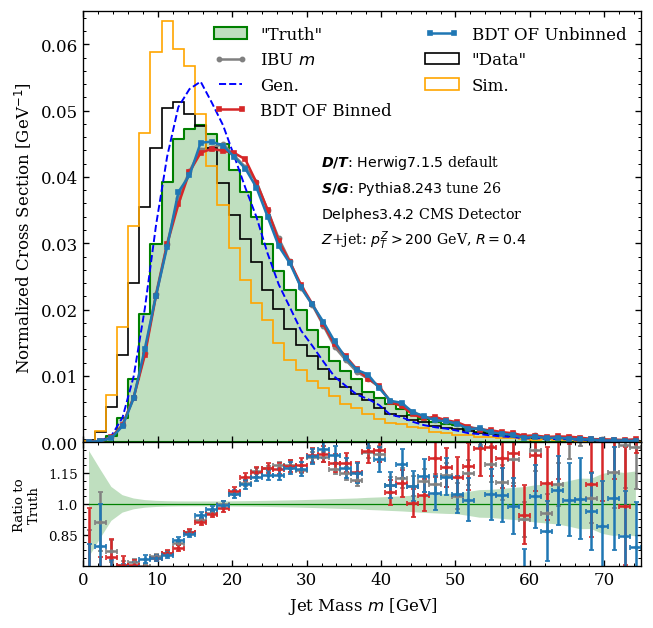

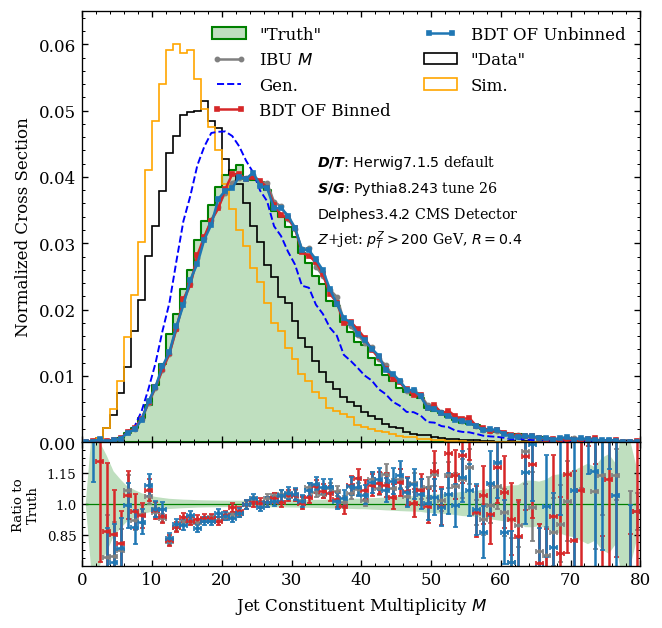

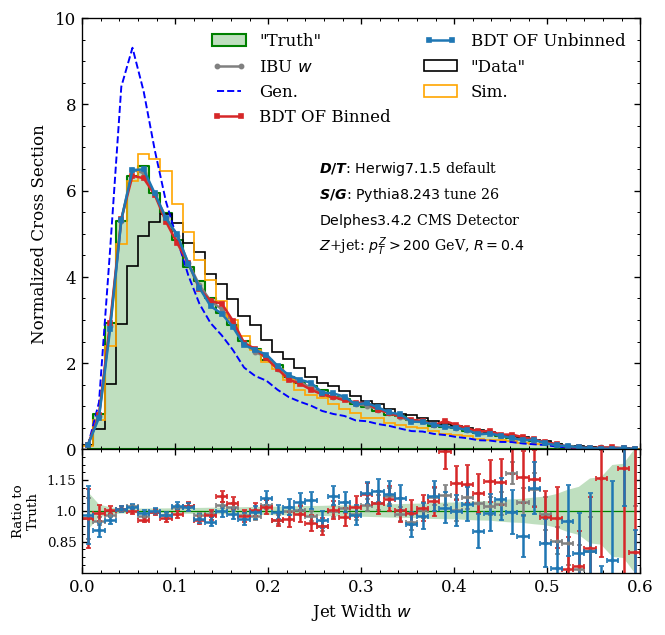

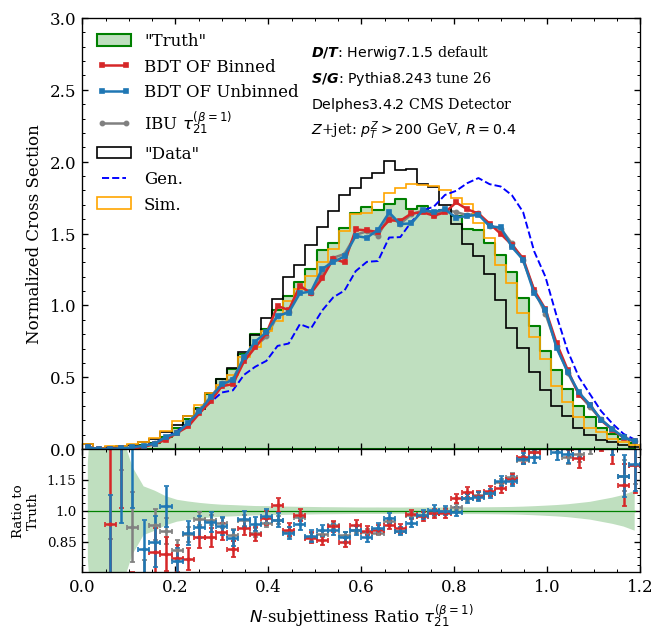

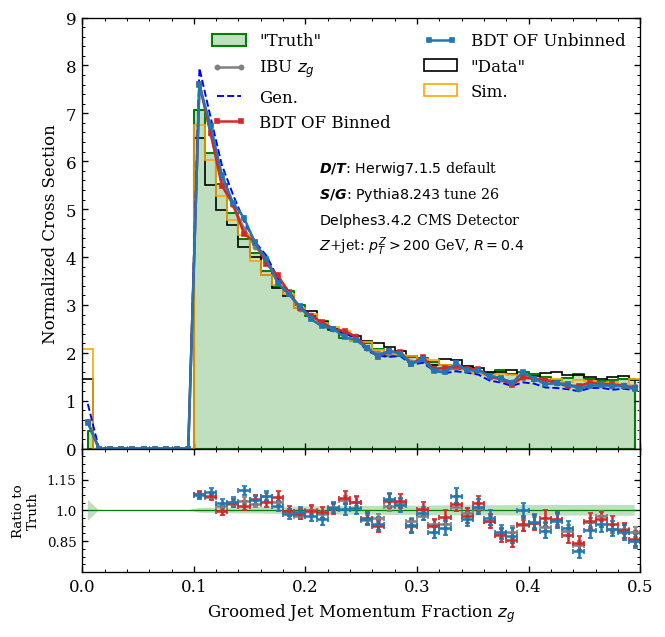

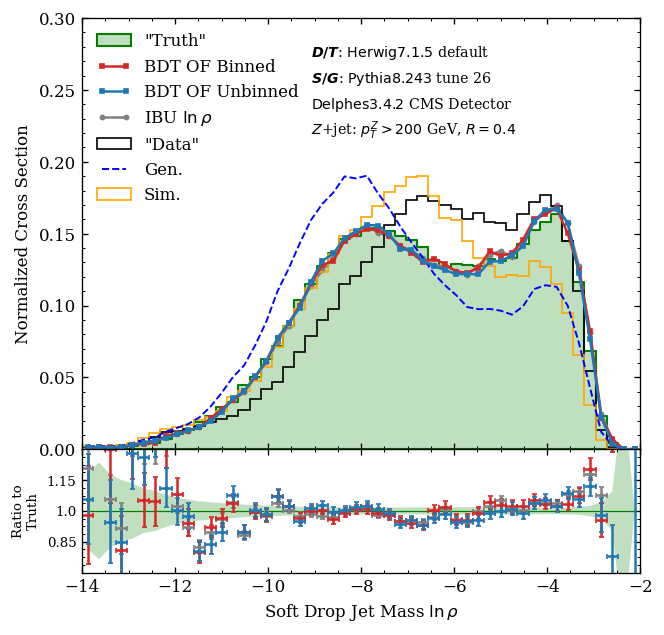

In [75]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob, figsize=(6,6))
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])
        
    # Plot the Different Distributions of the Observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='"Data"', **hist_style)
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    # plot the IBU distribution
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    
    # # Plot the Unfolded Distributions of the Observable
    # # plot the OmniFold distribution
    of_histgen_binned, of_histgen_unc_binned = modplot.calc_hist(
        binned_results[i][1].flatten(), 
        weights=binned_results[i][0][-1][1], 
        bins=ob['bins_mc'], 
        density=True
    )[:2]

    of_histgen_unbinned, of_histgen_unc_unbinned = modplot.calc_hist(
        unbinned_results[i][1].flatten(), 
        weights=unbinned_results[i][0][-1][1], 
        bins=ob['bins_mc'], 
        density=True
    )[:2]

    ax0.plot(ob['midbins_mc'], of_histgen_binned, **binned_omnifold_style, label='BDT OF Binned')
    ax0.plot(ob['midbins_mc'], of_histgen_unbinned, **unbinned_omnifold_style, label='BDT OF Unbinned')


    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][itnum]/(ob['truth_hist'] + 10**-50)

    of_ratio_binned = of_histgen_binned/(ob['truth_hist'] + 10**-50)
    of_ratio_unbinned = of_histgen_unbinned/(ob['truth_hist'] + 10**-50)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)

    of_unc_ratio_binned = of_histgen_unc_binned / (ob['truth_hist'] + 10**-50)
    of_unc_ratio_unbinned = of_histgen_unc_unbinned / (ob['truth_hist'] + 10**-50)

    ax1.fill_between(
        ob['midbins_mc'], 
        1 - truth_unc_ratio, 
        1 + truth_unc_ratio,          
        facecolor=truth_style['facecolor'], 
        zorder=-2
    )
    
    ax1.errorbar(
        ob['midbins_mc'], 
        ibu_ratio, 
        xerr=ob['binwidth_mc']/2, 
        yerr=ibu_unc_ratio,                       
        color=ibu_style['color'], 
        **modplot.style('errorbar')
    ) # IBU Error Bar
    
    ax1.errorbar(
        ob['midbins_mc'], 
        of_ratio_binned, 
        xerr=ob['binwidth_mc']/2, 
        yerr=of_unc_ratio_binned, 
        color=binned_omnifold_style['color'], 
        **modplot.style('errorbar')
    ) # Binned Error Bar

    ax1.errorbar(
        ob['midbins_mc'], 
        of_ratio_unbinned, 
        xerr=ob['binwidth_mc']/2, 
        yerr=of_unc_ratio_unbinned, 
        color=unbinned_omnifold_style['color'], 
        **modplot.style('errorbar')
    ) # Unbinned Error Bar


    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 5, 6, 0, 1] if ncol==2 else [3, 5, 6, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\boldsymbol{D/T}$: $\mathsf{Herwig 7.1.5}$ default',
                  line_1=r'$\boldsymbol{S/G}$: $\mathsf{Pythia 8.243}$ tune 26',
                  line_2=r'$\mathsf{Delphes 3.4.2}$ CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig(f'plots/BDT_OmniFold_{obkey}.png', bbox_inches='tight')
    plt.show()